In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import scipy.signal as signal
from mpl_toolkits.mplot3d import Axes3D
import time

In [204]:
''' caozhoujian function taylorT2'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return m1,m2
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
def F_cross(theta,psi,phi):
    return 0.5*(1+np.power(np.cos(theta),2))*np.cos(2*phi)*np.sin(2*psi)-np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)
def F_plus(theta,psi,phi):
    return -0.5*(1+np.power(np.cos(theta),2))*np.cos(2.0*phi)*np.cos(2*psi)-np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
def D_eff(D,theta,psi,phi,iota):
    return D/(np.sqrt(np.power(F_cross(theta,psi,phi),2.0)*np.power(np.cos(iota),2.0)+np.power(F_plus(theta,psi,phi),2)*0.25*(1+np.power(np.cos(iota),2))))
def Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c,v_lso=1/np.sqrt(6.0)):
    Mcal=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal*f,1/3.0)
    return 2*sciconsts.pi*f*t_c-phi_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v/v_lso))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c):
    return np.power(m_c,5.0/6.0)/D_eff(D,theta,psi,phi,iota)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c))
def Psi2(f,m_c,smr):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))

def h_mod(f,m_c,smr):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi2(f,m_c,smr))*1e-48



    
'''MY FUNCTION PROJECT1'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acal(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def D1acal(t,k_1,t_gas,t_0):
    a1=acal(t,k_1,t_gas,t_0)
    return -k_1*np.power(a1,-3.0)-a1/t_gas
def D2acal(t,k_1,t_gas,t_0):
    a2=acal(t,k_1,t_gas,t_0)
    D1a2=D1acal(t,k_1,t_gas,t_0)
    return (3.0*k_1/np.power(a2,4.0)+1/t_gas)*D1a2
def Omegacal(t,k_1,t_gas,t_0,m_1,m_2):
    return np.power(sciconsts.G*(m_1+m_2)/np.power(acal(t,k_1,t_gas,t_0),3.0),0.5)
def D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2):
    a3=acal(t,k_1,t_gas,t_0)
    D1a3=D1acal(t,k_1,t_gas,t_0)
    o1=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    return -1.5*D1a3/a3*o1
def D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2):
    a4=acal(t,k_1,t_gas,t_0)
    D1a4=D1acal(t,k_1,t_gas,t_0)
    D2a4=D2acal(t,k_1,t_gas,t_0)
    o2=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    return 15.0/4.0*np.power(D1a4/a4,2.0)-1.5*D2a4/a4*o2
#reduced D^2(q_ij)
#D^2(q_xx-q_yy)    1
#D^2(q_xx+q_yy)    2
#D^2q_xy           3
#D^2q_zz=-D^2(q_xx+q_yy) 4
'''def helpnumber(n,t,r,k_1,t_gas,t_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=acal(t,k_1,t_gas,t_0)
    D1a5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2a5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    o5=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D1o5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2o5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    if n==1:
        return mu5*(-4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*np.power(o5,2.0)-8.0*a5*o5*np.sin(2.0*t*o5)*D1a5+2.0*np.cos(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*o5*D1o5-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*D1o5-8.0*t*a5*np.sin(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.cos(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.cos(2.0*t*o5)*D2a5-2.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*D2o5)
    elif n==3:
        return mu5*(-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*np.power(o5,2.0)+8.0*a5*o5*np.cos(2.0*t*o5)*D1a5+2.0*np.sin(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*o5*D1o5+4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*D1o5+8.0*t*a5*np.cos(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.sin(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.sin(2.0*t*o5)*D2a5+2.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*D2o5)
    elif n==2:
        return 2.0/3.0*mu5(D2a5*a5+np.power(D1a5,2.0))
    elif n==4:
        return -2.0/3.0*mu5(D2a5*a5+np.power(D1a5,2.0))''' 

'''all in SI unit'''
def h_plus(t,r,theta,k_1,t_gas,t_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=acal(t,k_1,t_gas,t_0)
    D1a5=D1acal(t,k_1,t_gas,t_0)
    D2a5=D2acal(t,k_1,t_gas,t_0)
    o5=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D1o5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2o5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    hp1_1=mu5*(-4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*np.power(o5,2.0)-8.0*a5*o5*np.sin(2.0*t*o5)*D1a5+2.0*np.cos(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*o5*D1o5-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*D1o5-8.0*t*a5*np.sin(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.cos(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.cos(2.0*t*o5)*D2a5-2.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*D2o5)
    hp2_3=2.0/3.0*mu5*(D2a5*a5+np.power(D1a5,2.0))
    return (sciconsts.G/np.power(sciconsts.c,3.0))/r*(1.0/2.0*(1+np.power(np.cos(theta),2.0))*hp1_1-np.power(np.sin(theta),2.0)*1.5*hp2_3)
def h_cross(t,r,theta,k_1,t_gas,t_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=acal(t,k_1,t_gas,t_0)
    D1a5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2a5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    o5=Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D1o5=D1Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    D2o5=D2Omegacal(t,k_1,t_gas,t_0,m_1,m_2)
    hp2_2=mu5*(-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*np.power(o5,2.0)+8.0*a5*o5*np.cos(2.0*t*o5)*D1a5+2.0*np.sin(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*o5*D1o5+4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*D1o5+8.0*t*a5*np.cos(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.sin(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.sin(2.0*t*o5)*D2a5+2.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*D2o5)
    return (sciconsts.G/np.power(sciconsts.c,4.0))/r*np.cos(theta)*hp2_2

def a_modcal(t,k_1,a_0):
    return np.power((np.power(a_0,4.0)-4*k_1*t),0.25)
def D1a_modcal(t,k_1,a_0):
    a1=a_modcal(t,k_1,a_0)
    return -k_1*np.power(a1,-3.0)
def D2a_modcal(t,k_1,a_0):
    a2=a_modcal(t,k_1,a_0)
    D1a2=D1a_modcal(t,k_1,a_0)
    return -3.0*np.power(D1a2,2.0)/a2
def Omega_modcal(t,k_1,a_0,m_1,m_2):
    return np.power(sciconsts.G*(m_1+m_2)/np.power(a_modcal(t,k_1,a_0),3.0),0.5)
def D1Omega_modcal(t,k_1,a_0,m_1,m_2):
    a3=a_modcal(t,k_1,a_0)
    D1a3=D1a_modcal(t,k_1,a_0)
    o1=Omega_modcal(t,k_1,a_0,m_1,m_2)
    return -1.5*D1a3/a3*o1
def D2Omega_modcal(t,k_1,a_0,m_1,m_2):
    a4=a_modcal(t,k_1,a_0)
    D1a4=D1a_modcal(t,k_1,a_0)
    D2a4=D2a_modcal(t,k_1,a_0)
    o2=Omega_modcal(t,k_1,a_0,m_1,m_2)
    return 15.0/4.0*np.power(D1a4/a4,2.0)-1.5*D2a4/a4*o2

def hmod_plus(t,k_1,a_0,m_1,m_2):
    mu5=m_1*m_2/(m_1+m_2)
    a5=a_modcal(t,k_1,a_0)
    D1a5=D1a_modcal(t,k_1,a_0)
    D2a5=D2a_modcal(t,k_1,a_0)
    o5=Omega_modcal(t,k_1,a_0,m_1,m_2)
    D1o5=D1Omega_modcal(t,k_1,a_0,m_1,m_2)
    D2o5=D2Omega_modcal(t,k_1,a_0,m_1,m_2)
    hp1_1=mu5*(-4.0*np.power(a5,2.0)*np.cos(2.0*t*o5)*np.power(o5,2.0)-8.0*a5*o5*np.sin(2.0*t*o5)*D1a5+2.0*np.cos(2.0*t*o5)*np.power(D1a5,2.0)-8.0*t*np.power(a5,2.0)*np.cos(2.0*t*o5)*o5*D1o5-4.0*np.power(a5,2.0)*np.sin(2.0*t*o5)*D1o5-8.0*t*a5*np.sin(2.0*t*o5)*D1o5*D1a5+4.0*np.power(t*a5,2.0)*np.cos(2.0*t*o5)*np.power(D1o5,2.0)+2.0*a5*np.cos(2.0*t*o5)*D2a5-2.0*t*np.power(a5,2.0)*np.sin(2.0*t*o5)*D2o5)
    return (sciconsts.G/np.power(sciconsts.c,3.0))/(10e23)*(hp1_1)

def freq_ana(f,N):
    jugg=np.where(f>=f.max()*0.95)
    ni=jugg[0][0]
    nf=jugg[0][jugg[0].size-1]
    dfi=(0.01-0.0001)/N
    fi=0.0001+dfi*ni
    ff=0.0001+dfi*nf
    return (fi,f[ni]),(ff,f[nf])


'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''





def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)

In [4]:
m_sun=1.9891e30
m_1=10*m_sun
m_2=10*m_sun
t_gas=1000.0*365*24*3600
a_0=3.0e8

In [5]:
k_1=k_1cal(m_1,m_2)
t_0=t_0cal(m_1,m_2,t_gas,a_0)
theta=0.0
years=365*24*3600.0
N=10000000
t_scale=4*years
r=10*1e6*3.261*sciconsts.light_year
t=np.linspace(0,t_scale,num=N)
(t_scale*0.01*4,N/0.01/t_scale,t_scale) 

(5045760.0, 7.927447995941146, 126144000.0)

In [6]:
T=t_scale/N
fs=1.0/T
y=h_plus(t,r,theta,k_1,t_gas,t_0,m_1,m_2)
1.0/t_scale

7.927447995941146e-09

In [7]:
xs=np.linspace(0,1/2.0/T,num=N//2)
yff=fft.fft(y)
y_abs=abs(yff)
ys=np.zeros((N//2,), dtype=np.float64)
ys=2.0/N*y_abs[0:N//2]
hs=sci_interpolate.interp1d(xs,ys,kind='cubic')
hr1=2.0/N*yff.real[0:N//2]
hi1=2.0/N*yff.imag[0:N//2]
hreal=sci_interpolate.interp1d(xs,hr1,kind='cubic')
himag=sci_interpolate.interp1d(xs,hi1,kind='cubic')
#A=np.sqrt(sci_integrate.quad(lambda x:hs(x)*hs(x)/S_n_lisa(x),1.0e-4,0.01))

In [371]:
t1=time.clock() 
m_1=42*m_sun 
m_2=42*m_sun 
a_0=484618279.8606534*0.9
k_1=k_1cal(m_1,m_2) 
N=10000000 
t_scale=4*years 
t=np.linspace(0,t_scale,num=N) 
T=t_scale/N 
fs=1.0/T 
y_mod=hmod_plus(t,k_1,a_0,m_1,m_2) 
xs=np.linspace(0,1/2.0/T,num=N//2) 
yff=fft.fft(y_mod) 
y_mod_abs=abs(yff) 
y_mods=np.zeros((N//2,), dtype=np.float64) 
y_mods=2.0/N*y_mod_abs[0:N//2] 
a=freq_ana(y_mods,N)
df=a[1][0]-a[0][0]
B=(a[0][1]+a[1][1])/2*df/S_n_lisa((a[1][0]+a[0][0])/2)
t2=time.clock()
B,t2-t1

(2061313773570728.0, 20.939111000000025)

In [401]:
t1=time.clock() 
m_1=42.3*m_sun 
m_2=42.3*m_sun 
a_0=484618279.8606534
k_1=k_1cal(m_1,m_2) 
N=5000000 
t_scale=4*years 
t=np.linspace(0,t_scale,num=N) 
T=t_scale/N 
fs=1.0/T 
y_mod=hmod_plus(t,k_1,a_0,m_1,m_2) 
xs=np.linspace(0,1/2.0/T,num=N//2) 
yff=fft.fft(y_mod) 
y_mod_abs=abs(yff) 
y_mods=np.zeros((N//2,), dtype=np.float64) 
y_mods=2.0/N*y_mod_abs[0:N//2] 
h_mods=sci_interpolate.interp1d(xs,y_mods,kind='cubic') 
h_modr1=2.0/N*yff.real[0:N//2] 
h_modi1=2.0/N*yff.imag[0:N//2] 
h_modreal=sci_interpolate.interp1d(xs,h_modr1,kind='cubic') 
h_modimag=sci_interpolate.interp1d(xs,h_modi1,kind='cubic') 
AB=sci_integrate.quad(lambda x:(h_modreal(x)*hreal(x)+h_modimag(x)*himag(x))/S_n_lisa(x),1.0e-4,0.01) 
B=np.sqrt(sci_integrate.quad(lambda x:np.power(h_mods(x),2.0)/S_n_lisa(x),1.0e-4,0.01)) 
t2=time.clock()
(B,t2-t1)
#A,B,AB,((abs(AB[0])+AB[1])/(A[0]-A[1])/(B[0]-B[1]),),t2-t1

(array([ 64.32505699,   6.41737644]), 18.7857019999999)

In [402]:
fu=np.linspace(0.0001,0.01,100000)
dfu=(0.01-0.0001)/100000.0
work4=h_mods(fu)
work5=h_modreal(fu)
work6=h_modimag(fu)
work7=hreal(fu)
work8=hs(fu)*h_mods(fu)
work9=himag(fu)
work10=h_modreal(fu)*hreal(fu)+h_modimag(fu)*himag(fu)
work11=np.arctan(himag(fu)/hreal(fu))
work12=np.arctan(h_modimag(fu)/h_modreal(fu))

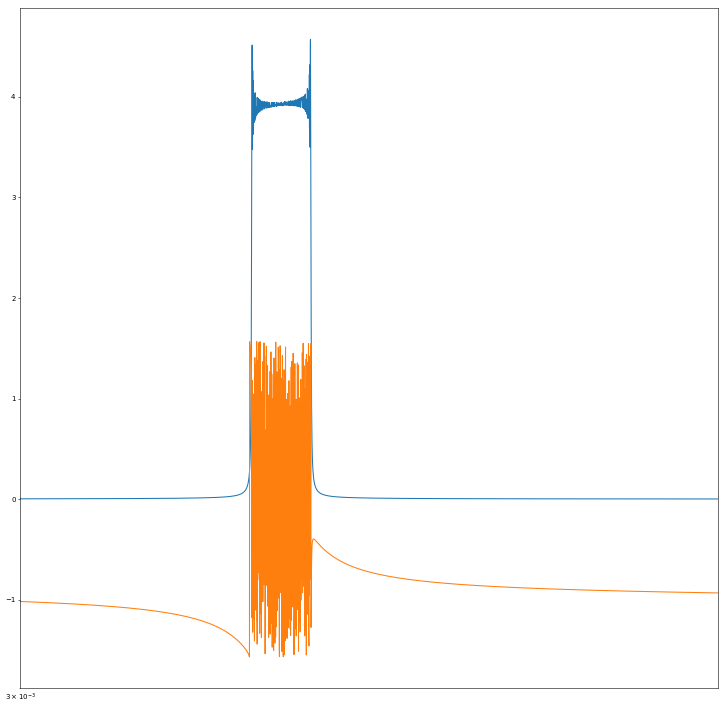

In [424]:
fig1=plt.figure(figsize=(18,18),dpi=50)
work14=work11-work12
work16=hs(fu)
work17=himag(fu)/hreal(fu)
#plt.plot(fu,work16*1e17)
#plt.plot(fu,work11)
plt.plot(fu,work16*1e17)
plt.plot(fu,work11)
#plt.plot(fu,work16*1e17)
#plt.yscale('log')
plt.xscale('log')
plt.xlim(0.003,0.003498)
plt.show()

freq_ana(work12,1000000),freq_ana(work4,1000000)

In [405]:
sci_integrate.quad(lambda fu:(h_modreal(fu)*hreal(fu)+h_modimag(fu)*himag(fu))/S_n_lisa(fu),1.0e-4,0.01)
#1168/18/63.0
#np.cos(work14)[60000:100000].min()

(7.200453975556313, 96.75184019687822)

In [397]:
freq_ana(work11,100000),freq_ana(work12,100000)

(((0.0031552390000000002, 1.5651631246635263),
  (0.003198106, 1.5462402949388014)),
 ((0.0031379140000000003, 1.4881810329878742),
  (0.0031913740000000003, 1.5659440980707435)))

In [210]:
jugg=np.where(work4>=work4.max()*0.95)
ni=jugg[0][0]
nf=jugg[0][jugg[0].size-1]
fi=np.power(10.0,2.0/1000000*ni-4)
ff=np.power(10.0,2.0/1000000*nf-4)
fi,ff

(0.00030062978066760907, 0.0003067707866541659)

In [230]:
sci_integrate.quad(lambda x:np.power(hs(x),2.0)/S_n_lisa(x),1.0e-4,0.01)

(351.16815365439345, 3.773939342021322)

In [347]:
freq_ana(work12,100000),freq_ana(work4,100000)

(((0.0027494380000000003, 1.5677809275204491),
  (0.0027627040000000004, 1.5378662935444227)),
 ((0.002750428, 1.4266545745756038e-16),
  (0.0027652780000000004, 1.4754791968644986e-16)))

In [251]:
np.sqrt(0.00004*h_mods(0.00317)*h_mods(0.00317)/S_n_lisa(0.00317))

62.523557653285692

In [106]:
h_plussave=np.zeros((10000000,2))
h_modsave=np.zeros((10000000,2))

In [108]:
h_plussave[:,0]=t
h_modsave[:,0]=t
h_plussave[:,1]=y
h_modsave[:,1]=y_mod

In [110]:
np.savetxt('h_plussave.txt',h_plussave)
np.savetxt('h_modsave.txt',h_modsave)

In [112]:
np.power(11,0.2)

1.6153942662021781

In [111]:
solvem(11,0.25)

(12.635681904967385, 12.635681904967385)

In [110]:
8.3847907426330651e+31/m_sun

42.15369133091883

In [114]:
1.6153942662021781*3e8

484618279.8606534

In [179]:
m=np.array([1,2]).max()

In [243]:
np.arctan(hi1/hr1)

array([  0.00000000e+00,  -4.49752930e-06,  -8.16128372e-06, ...,
        -4.82586989e-07,  -1.00056890e-06,  -7.19869372e-07])

In [280]:
y=np.cos(np.arctan(hi1/hr1))
y2=fft.fft(y)
y3=abs(y2)[0:Nf/2]*2/Nf
phi3=np.arctan(y2.imag/y2.real)[0:Nf/2]
tf_scale=1.0/2/T
Nf=N/2
Tf=tf_scale/Nf
fff=np.linspace(0,1.0/2/Tf,Nf/2)

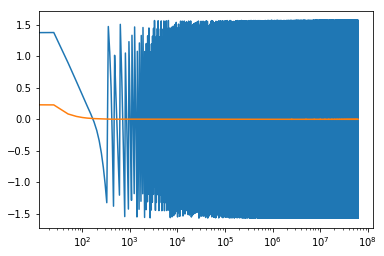

In [284]:
#plt.plot(fff,y3)
plt.rcParams['agg.path.chunksize'] = 100000
plt.plot(fff,phi3)
plt.plot(fff,y3)
#plt.yscale('log')
plt.xscale('log')
#plt.xlim(0.00315,0.00322)
plt.show()

In [270]:
y3=abs(y2)

10000000

In [263]:
fff

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [267]:
fff

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [364]:
a=freq_ana(y_mods,N)

In [369]:
a[0][1]

1.2526783679121556e-16

In [373]:
22*10000/3600

61

In [415]:
np.power(sciconsts.G*m_sun/3e8,3.0)*2000/np.power(sciconsts.c,5.0)

7.1566008110747329e-05

In [419]:
np.power(sciconsts.G*(20*m_sun)/np.power(3e8,3.0),0.5)

0.009916470596754488

In [421]:
1000*years

31536000000.0